In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




2025-11-23 17:10:58.016462: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 17:10:58.030117: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 17:10:58.479075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 17:11:00.163661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [13]:
# Chargement
#df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')
#df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
#df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')
#df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)
#df_weekly = df_weekly.drop(columns=['Average Users'])

def build_flexible_timeseries_views(df):
    """
    df : DataFrame avec index DateTime déjà trié et colonnes numériques (Users, etc.)
    
    Retourne :
      df_daily_global  : toute la série, resamplée à 1 jour
      df_hourly_view   : partie horaire (1h + 10min agrégé à 1h), sans daily
      df_10min_view    : uniquement la partie 10min, sans hourly ni daily
    """
    df = df.sort_index().copy()
    
    # 1) Calcul des deltas temporels en secondes
    dt_seconds = df.index.to_series().diff().dt.total_seconds()

    # 2) Identifier début de chaque segment par fréquence
    #    1 jour = 86400s, 1h = 3600s, 10min = 600s
    start_hour = None
    start_10 = None
    
    if (dt_seconds == 3600).any():
        start_hour = df.index[dt_seconds == 3600].min()
    if (dt_seconds == 600).any():
        start_10 = df.index[dt_seconds == 600].min()
    
    print("Début segment horaire (1h) :", start_hour)
    print("Début segment 10min        :", start_10)
    
    # --- 1) Vue globale : toute la série resamplée à 1 jour ---
    df_daily_global = df.resample("1D").mean()
    
    # --- 2) Vue horaire : sans la partie daily ---
    # On commence à partir du début de l'horaire si disponible
    if start_hour is not None:
        df_no_daily = df.loc[start_hour:].copy()
        
        # On resample tout ça à 1h :
        # - la partie déjà horaire restera à 1h
        # - la partie 10min sera agrégée à 1h (moyenne)
        df_hourly_view = df_no_daily.resample("1H").mean()
    else:
        df_hourly_view = None
        print("Aucun segment horaire (1h) détecté, df_hourly_view = None")
    
    # --- 3) Vue 10min : uniquement la partie haute résolution ---
    if start_10 is not None:
        df_10min_view = df.loc[start_10:].copy()
        # On sécurise : resample exactement à 10min + moyenne
        df_10min_view = df_10min_view.resample("10min").mean()
    else:
        df_10min_view = None
        print(" Aucun segment 10min détecté, df_10min_view = None")
    
    return df_daily_global, df_hourly_view, df_10min_view

df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';')

df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')

# Nettoyage Users (en cas de virgules pour les milliers)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

# Pipeline flexible
df_daily_global, df_hourly_view, df_10min_view = build_flexible_timeseries_views(df_weekly)

print("daily:", df_daily_global.shape)
print("hourly:", None if df_hourly_view is None else df_hourly_view.shape)
print("10min:", None if df_10min_view is None else df_10min_view.shape)

data = df_daily_global.copy()

Début segment horaire (1h) : 2025-09-21 01:00:00
Début segment 10min        : 2025-10-14 14:10:00
daily: (7953, 3)
hourly: (734, 3)
10min: (1009, 3)


/tmp/ipykernel_95056/1265929843.py:46: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [14]:
# Variables explicatives 
data['weekday'] = data.index.weekday
data['hour'] = data.index.hour
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

# Cible à prédire : transformation log
data['Users_log'] = np.log1p(data['Users'])

# Moyennes glissantes

# ~1 jour en pas 10 min = 144 pas (24h * 6)
data['Users_log_rm_1d'] = data['Users_log'].rolling(144, min_periods=1).mean()

# ~7 jours en pas 10 min = 1008 pas (144 * 7)
data['Users_log_rm_7d'] = data['Users_log'].rolling(1008, min_periods=1).mean()

# Différence rapide (variation instantanée)
data['Users_log_diff'] = data['Users_log'].diff()

features = [
    'Users_log',          # niveau
    'Users_log_rm_1d',    # trend lisse
    'Users_log_rm_7d',    # tendance hebdo (rolling vers le passé
    'Users_log_diff',     # micro-variation
    'In-Game',            # signal d'activité
    'weekday', 'hour', 'is_weekend' # variables temporelles
]

dataset = data[features].dropna()  

# Paramètres de fenêtrage
base_seq_hours = 24 * 7  # 1 semaine de contexte
seq_length = min(base_seq_hours, train_size - 10)   # ~1 semaine à pas 10 min
aligned = dataset.copy()
N = len(aligned)
train_size = int(N * 0.8)

if train_size <= seq_length + 10:
    raise ValueError(f"Pas assez de données: train_size={train_size}, seq_length={seq_length}")

# Scaling (fit sur train uniquement)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(aligned.iloc[:train_size])
scaled_test  = scaler.transform(aligned.iloc[train_size:])
scaled = np.vstack([scaled_train, scaled_test])


target_idx = aligned.columns.get_loc('Users_log')

X, y = [], []
for i in range(len(scaled) - seq_length - 1):
    # séquence [i .. i+seq_length-1]
    X.append(scaled[i:i+seq_length, :])
    # cible = Users_log au pas suivant (i+seq_length)
    y.append(scaled[i + seq_length, target_idx])

X = np.array(X); y = np.array(y)

# Split temporel (train/test)

split_idx = train_size - seq_length - 1
if split_idx <= 0:
    raise ValueError(f"split_idx <= 0 ({split_idx}). Réduis seq_length.")

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
N = len(df_hourly_view)
train_size = int(N * 0.8)
print("N =", N)
print("train_size =", train_size)
print("seq_length =", seq_length)
print("start =", df_hourly_view.index.min())
print("end   =", df_hourly_view.index.max())


N = 734
train_size = 587
seq_length = 168
start = 2025-09-21 01:00:00
end   = 2025-10-21 14:00:00


/home/florian/TSM_AnsecData/projet_ansecdata/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0341 - mae: 0.1247 - val_loss: 0.0031 - val_mae: 0.0472
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0071 - mae: 0.0665 - val_loss: 0.0032 - val_mae: 0.0498
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0061 - mae: 0.0621 - val_loss: 0.0044 - val_mae: 0.0502
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0055 - mae: 0.0589 - val_loss: 0.0031 - val_mae: 0.0484
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0053 - mae: 0.0575 - val_loss: 0.0038 - val_mae: 0.0530
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0046 - mae: 0.0534 - val_loss: 0.0018 - val_mae: 0.0348
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0044 - mae: 0.0532 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0045 - mae: 0.0534 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.

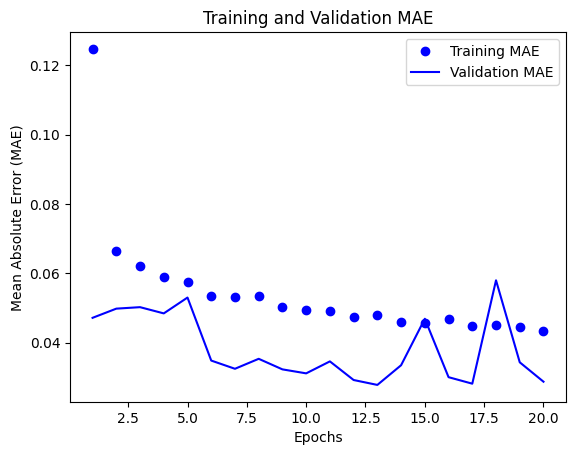

In [15]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Plotting results: Training and validation MAE
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")  
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()

on peut s'arrêter à 20 epoch pour gagner du temps

MAE  : 954,052.04
RMSE : 1,174,088.30
R²   : 0.9439
MAPE : 3.24 %


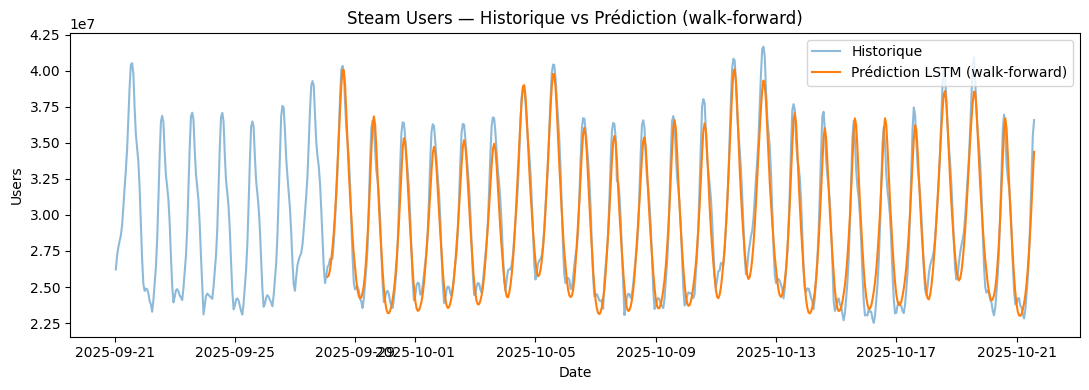

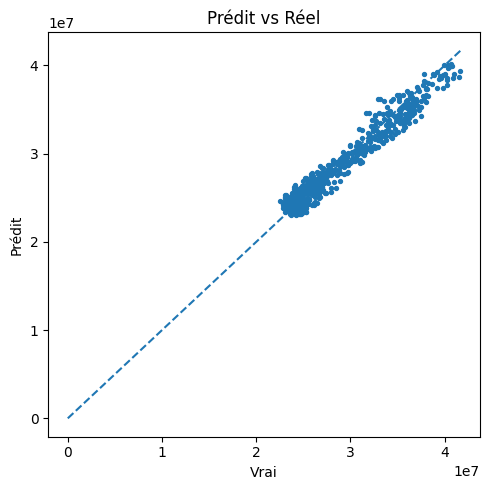

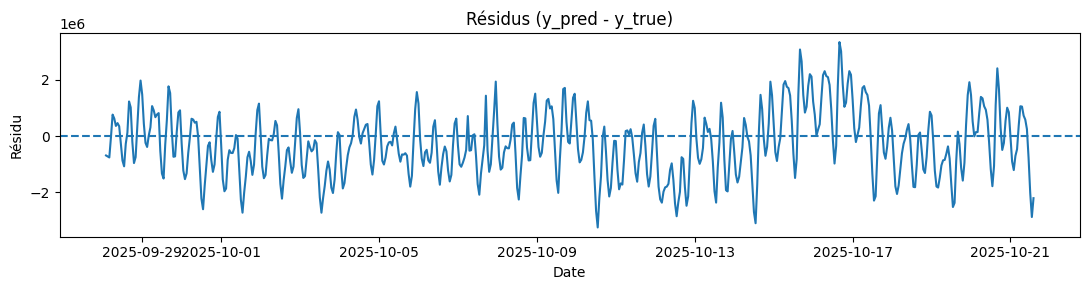

In [9]:
# Walk-forward : prédiction de Users_log (t+1)

y_pred_scaled = []
for i in range(len(scaled) - seq_length):
    seq = scaled[i:i+seq_length].reshape(1, seq_length, scaled.shape[1])
    y_pred_scaled.append(model.predict(seq, verbose=0)[0][0])
y_pred_scaled = np.array(y_pred_scaled)

# Repasser de l'échelle 'scaled' à l'échelle d'origine pour Users_log 
tmp_pred = np.zeros((len(y_pred_scaled), scaled.shape[1]))
tmp_pred[:, target_idx] = y_pred_scaled

inv_pred_log = scaler.inverse_transform(tmp_pred)[:, target_idx]  # Users_log prédit  (t+1)

# Vérité 
true_log = aligned['Users_log'].iloc[seq_length:].to_numpy()

# Retour au niveau Users linéaire
pred_users = np.expm1(inv_pred_log)
true_users = np.expm1(true_log)

# Dates alignées (la 1re prédiction correspond à l'index seq_length)
dates = aligned.index[seq_length:]

# Métriques
mae  = mean_absolute_error(true_users, pred_users)
rmse = root_mean_squared_error(true_users, pred_users)  
r2   = r2_score(true_users, pred_users)
mape = (np.abs((true_users - pred_users) / np.where(true_users == 0, 1e-9, true_users))).mean() * 100

print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:,.4f}")
print(f"MAPE : {mape:,.2f} %")

# Visualisations 
plt.figure(figsize=(11,4))
plt.plot(data.index, data['Users'], label='Historique', alpha=0.5)
plt.plot(dates, pred_users, label='Prédiction LSTM (walk-forward)')
plt.title("Steam Users — Historique vs Prédiction (walk-forward)")
plt.xlabel("Date"); plt.ylabel("Users"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(true_users, pred_users, s=8)
m = max(true_users.max(), pred_users.max())
plt.plot([0, m], [0, m], '--')
plt.xlabel("Vrai"); plt.ylabel("Prédit"); plt.title("Prédit vs Réel")
plt.tight_layout(); plt.show()

resid = pred_users - true_users
plt.figure(figsize=(11,3))
plt.plot(dates, resid); plt.axhline(0, ls='--')
plt.title("Résidus (y_pred - y_true)"); plt.xlabel("Date"); plt.ylabel("Résidu")
plt.tight_layout(); plt.show()



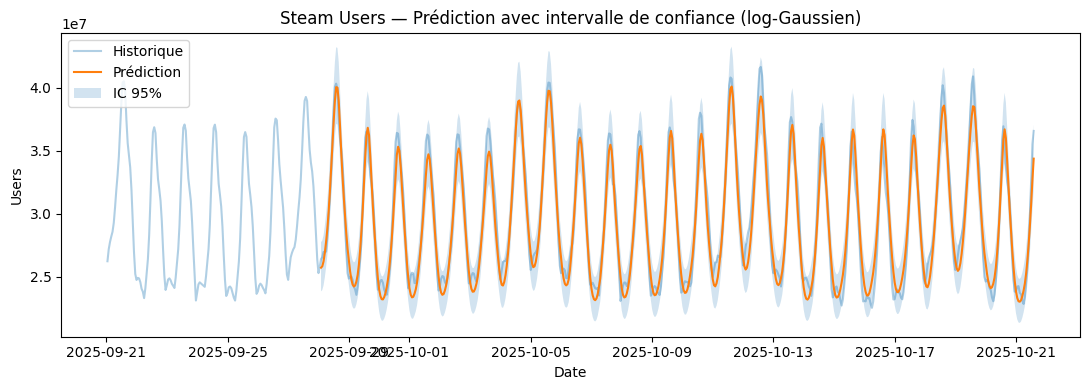

In [10]:
import numpy as np
from scipy.stats import norm

# inv_pred_log = predicted Users_log (non-scaled)
# true_log     = true Users_log (non-scaled)

z = norm.ppf(0.975)  # 1.96
resid_log = true_log - inv_pred_log
sigma = np.std(resid_log, ddof=1)

pi_low_log = inv_pred_log - z * sigma
pi_hi_log  = inv_pred_log + z * sigma
pi_low = np.expm1(pi_low_log)
pi_hi  = np.expm1(pi_hi_log)

# Plot avec Matplotlib 
plt.figure(figsize=(11,4))
plt.plot(data.index, data['Users'], label='Historique', alpha=0.35)
plt.plot(dates, pred_users, label='Prédiction', linewidth=1.5)

# confidence band
plt.fill_between(dates, pi_low, pi_hi, alpha=0.2, label='IC 95%')

plt.title("Steam Users — Prédiction avec intervalle de confiance (log-Gaussien)")
plt.xlabel("Date"); plt.ylabel("Users"); plt.legend(); plt.tight_layout(); plt.show()


In [11]:
import pandas as pd

resid_log_series = pd.Series(resid_log, index=dates)
sigma_roll = resid_log_series.rolling(288, min_periods=60).std()  # ~2 jours à 10 min

pi_low_log = inv_pred_log - z * sigma_roll.to_numpy()
pi_hi_log  = inv_pred_log + z * sigma_roll.to_numpy()

mask = np.isnan(pi_low_log)
pi_low_log[mask] = inv_pred_log[mask] - z * sigma
pi_hi_log[mask]  = inv_pred_log[mask]  + z * sigma

pi_low = np.expm1(pi_low_log)
pi_hi  = np.expm1(pi_hi_log)


In [12]:
import plotly.graph_objects as go
import pandas as pd

df_plot = pd.DataFrame({
    "date": dates,
    "true": true_users,
    "pred": pred_users,
    "low":  pi_low,
    "high": pi_hi
})

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Users'], name="Historique",
                         mode="lines", opacity=0.35, hovertemplate="%{y:.0f} users<extra>Historique</extra>"))
fig.add_trace(go.Scatter(x=df_plot["date"], y=df_plot["pred"], name="Prédiction",
                         mode="lines", hovertemplate="%{y:.0f} users<extra>Prédiction</extra>"))

# Confidence band 
fig.add_trace(go.Scatter(
    x=df_plot["date"], y=df_plot["high"], name="IC 95% (haut)",
    mode="lines", line=dict(width=0), showlegend=False, hoverinfo="skip"
))
fig.add_trace(go.Scatter(
    x=df_plot["date"], y=df_plot["low"], name="IC 95%",
    mode="lines", line=dict(width=0), fill="tonexty", opacity=0.2,
    hoverinfo="skip"
))

fig.update_layout(
    title="Steam Users — Prédiction (interactive) avec IC 95%",
    xaxis_title="Date", yaxis_title="Users", hovermode="x unified"
)
fig.show()
